In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

In [2]:
def to_unix_time(dt):
    epoch = datetime.utcfromtimestamp(0)
    return (dt - epoch).total_seconds() * 1000

In [13]:
df = pd.read_csv("../data/PEACH/hr_device.csv")

print "total number of lines =", len(df)

excluded_macs = ["00-17-0d-00-00-b0-00-cc",
                 "00-17-0d-00-00-b0-00-aa",
                 "00-17-0d-00-00-b0-00-87",]

df_clean = df[~df.mac.isin(excluded_macs) 
            & (df.charge > 0)]

lines_removed = len(df) - len(df_clean)
print "number of lines removed = ", lines_removed, "(", lines_removed*100/len(df), "%)"

df_clean.loc[:, "date"] = pd.to_datetime(df_clean.time, unit='s')
df_clean.set_index(df_clean["date"], inplace=True)
df_clean.head()

total number of lines = 154698
number of lines removed =  18168 ( 11 %)


,time,mac,charge,queueOcc,numTxOk,lat,long,date
date,,,,,,,,
2016-06-20 10:11:30,1466417490,00-17-0d-00-00-30-60-ef,20686,81,40,-1.0,-1.0,2016-06-20 10:11:30
2016-06-20 10:26:30,1466418390,00-17-0d-00-00-30-60-ef,20738,49,32,-1.0,-1.0,2016-06-20 10:26:30
2016-06-20 10:41:31,1466419291,00-17-0d-00-00-30-60-ef,20789,49,32,-1.0,-1.0,2016-06-20 10:41:31
2016-06-20 11:11:31,1466421091,00-17-0d-00-00-30-60-ef,20893,49,32,-1.0,-1.0,2016-06-20 11:11:31
2016-06-20 11:26:31,1466421991,00-17-0d-00-00-30-60-ef,20944,49,32,-1.0,-1.0,2016-06-20 11:26:31


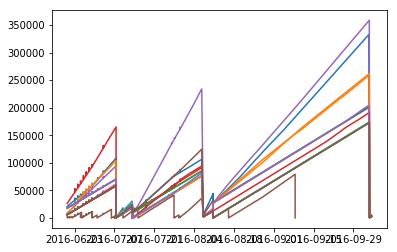

In [12]:
for name, group in df_clean.groupby(["mac"]):
    plt.plot(group.index, group.charge, label=name)
#plt.legend()

# Cleaning Charge


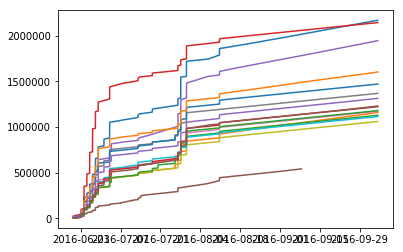

In [14]:
grouped = df_clean.groupby(["mac"])
charge_clean = []

for name, group in grouped:
    prev_charge = 0
    new_charge = 0
    charge_max = 0
    for curr_charge in group.charge:
        if curr_charge < prev_charge:
            new_charge += curr_charge
        else:
            new_charge += (curr_charge - prev_charge)
        charge_clean.append(new_charge)
        prev_charge = curr_charge

df_clean.loc[:, "charge_clean"] = pd.Series(charge_clean, index=df_clean.date)

for name, group in df_clean.groupby(["mac"]):
    plt.plot(group.index, group.charge_clean, label=name)

#plt.legend()
plt.show()

In [28]:
grouped = df_clean.groupby(["mac"])
stats = []
charge_tot = 2200 * 3600 # charge total in mC assuming 2200mAh battery

for name, group in grouped:    
    time_diff = group.time[len(group.time)-1] - group.time[0]
    if time_diff > 3600*24*30*2:
        charge_max = float(group.charge_clean.max())
        charge_left = charge_tot - charge_max
        time_left = float(charge_tot * time_diff) / charge_max
        stats.append([name[-8:],
                      "{:,} KC".format(int(round(charge_max)/1000)) +
                      " ({0}%) ".format(round(100*charge_max/charge_tot, 1)),
                      "{0} years".format(int(round(time_left/3600/24/365)))])
    
print pd.DataFrame(stats, columns=["MAC", "charge consumed", "lifetime"])\
    .set_index("MAC")\
    .to_latex(column_format="|c|c|c|")

\begin{tabular}{|c|c|c|}
\toprule
{} &    charge consumed & lifetime \\
MAC      &                    &          \\
\midrule
30-60-ef &  2,168 KC (27.4\%)  &  1 years \\
38-0f-66 &  1,159 KC (14.6\%)  &  2 years \\
3f-f8-20 &  1,128 KC (14.3\%)  &  2 years \\
3f-fe-87 &  2,142 KC (27.1\%)  &  1 years \\
3f-fe-88 &  1,944 KC (24.5\%)  &  1 years \\
58-32-36 &     542 KC (6.8\%)  &  3 years \\
60-01-f8 &  1,172 KC (14.8\%)  &  2 years \\
60-02-1b &  1,368 KC (17.3\%)  &  2 years \\
60-02-4b &  1,060 KC (13.4\%)  &  2 years \\
60-03-82 &  1,115 KC (14.1\%)  &  2 years \\
60-05-5f &  1,470 KC (18.6\%)  &  2 years \\
60-05-69 &  1,602 KC (20.2\%)  &  1 years \\
60-05-78 &  1,179 KC (14.9\%)  &  2 years \\
60-05-ab &  1,229 KC (15.5\%)  &  2 years \\
60-06-27 &  1,314 KC (16.6\%)  &  2 years \\
60-08-d5 &  1,222 KC (15.4\%)  &  2 years \\
\bottomrule
\end{tabular}

